There are three steps to creating the model.

1. **Vectorization**: We use a **Term Frequency Inverse Document Frequency** (TF-IDF) vectorizer to accomplish this. This is a common algorithm used to transform text into a meaningful representation of numbers used to fit machine algorithm for prediction. The TF-IDF object is pickled so that it can be used in the analysis of newer tweets later on. The threshold of the maximum and minimum document frequency has been set at 90 and 20 percent, respectively. In addition to this, a simple bag-of-words count vectorization is also applied to the Naive Bayes model just to see if there is a signficant difference in performance with different vecotirzation technique across the same model. The deep learning model also requires different kinds of preprocessing and that will be applied right before the CNN modeling.

2. **Train/Validation/Test Split**

3. **Modeling**: Modeling is conducted by using **logistic regression**, **Naive Bayes**, **CNN**, and **decision trees**. Hyperparameter tuning with GridSearch CV is also applied to all models for some optimizations apart from CNN.

Each model also has a ROC plot in order to assess performance.

In [4]:
import numpy as np
import re
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Test/train split
from sklearn.model_selection import train_test_split 

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer

# Convolutional neural network
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import Conv1D, Flatten, LSTM , GRU, GlobalMaxPooling1D
from keras import optimizers
from keras import models
from keras import losses
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from joblib import dump, load
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

# Import custom functions
from explore import tokenize
from explore import getTokenFreq
from evaluation import calculatePerformance
from evaluation import plotROCCurve
from evaluation import maxSeqLength

In [5]:
# Import dataset
df = pd.read_csv('../data/processed/data_for_modeling.csv')

# TF-IDF Vectorization

The TF-IDF method takes into account the 'rarity' of words within the vocabular and not only the frequency of the occurence. The minimum and maximum frequency is 2 and 0.9. We are taking the n-grams up to 3.

In [6]:
# Instantiate the tf-idf object
tfidfVectors = TfidfVectorizer(max_df=0.9, min_df=2, max_features=9000, stop_words='english', ngram_range=(1, 3))

The matrix has not been transformed yet because we need this instantiated object to make predictions on unseen text further down the pipeline of the project. By pickling only the fit object we can iteratively transform each time new text on the base fit matrix. Unseen words will just be dropped whenever they are not in the original fit matrix defined.

In [7]:
tfidfOnlyFit = tfidfVectors.fit(df['tweet_no_stopwords_no_short'])

In [8]:
# Pickling only the fit
pickleFit = open('tfidfOnlyFit', 'wb')
pickle.dump(tfidfOnlyFit, pickleFit)

In [9]:
tfidf = tfidfVectors.fit_transform(df['tweet_no_stopwords_no_short'])

In [10]:
dfVector = pd.DataFrame(tfidf.todense(), columns = tfidfVectors.get_feature_names())

# Test/Validation/Test Split

In [11]:
target = df['neg_label']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(dfVector, target, test_size = .2, random_state = 101)

In [13]:
print('Shape of training set:\t', x_train.shape)
print('Shape of training target:\t', y_train.shape)
print('Shape of test set:\t', x_test.shape)
print('Shape of test target:\t', y_test.shape)

Shape of training set:	 (33593, 9000)
Shape of training target:	 (33593,)
Shape of test set:	 (8399, 9000)
Shape of test target:	 (8399,)


In [14]:
X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = 101)

In [15]:
print('Shape of final training set:\t', X_train.shape)
print('Shape of final training target:\t', Y_train.shape)
print('Shape of validation set:\t', x_val.shape)
print('Shape of validation target:\t', y_val.shape)

Shape of final training set:	 (26874, 9000)
Shape of final training target:	 (26874,)
Shape of validation set:	 (6719, 9000)
Shape of validation target:	 (6719,)


# Logistic Regression Baseline

In [16]:
logmod = LogisticRegression(random_state = 1002)

In [17]:
logmod.fit(X_train, Y_train)

LogisticRegression(random_state=1002)

In [18]:
Logistic_Regression_Training = calculatePerformance(logmod, X_train, Y_train, 'Logistic Regression Model')

In [19]:
Logistic_Regression_Training

,Model,F1,Accuracy,ROC_Score,Precision
0,Logistic Regression Model,0.98307,0.983516,0.997736,0.992056


In [20]:
Logistic_Regression_Validation = calculatePerformance(logmod, x_val, y_val, 'Logistic Regression Validation')

In [21]:
Logistic_Regression_Validation

,Model,F1,Accuracy,ROC_Score,Precision
0,Logistic Regression Validation,0.973551,0.974252,0.995978,0.986981


AttributeError: 'str' object has no attribute 'pop'

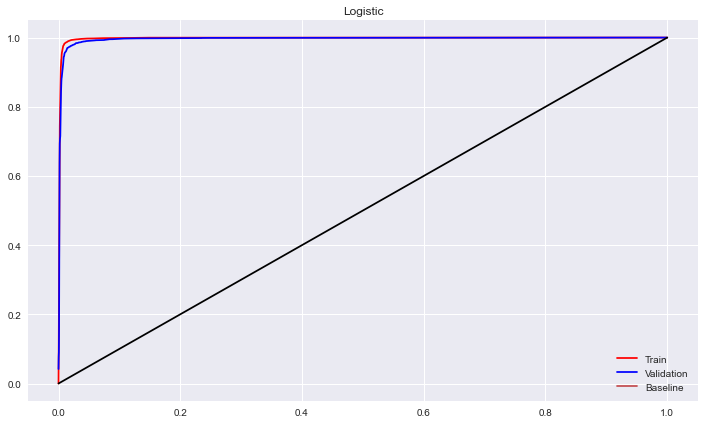

In [22]:
plotROCCurve(logmod, X_train, x_val, Y_train, y_val, "Logistic")

# CNN for Text Analysis

Neural networks analyze texts in a slightly different way with words as opposed to the sparse TF-IDF framework. Since this is a large dataset, a CNN may be able to pick up a pattern. Preprocessing with CNNs also requires it to be processed by Keras with the layer `Embedding.()` when it comes to the modeling

In [43]:
df.head(10)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_no_stopwords_no_short,neg_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,0
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#12...,0,these hoes got more bodies than a cemetery ...,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
3,a friend just told me she's afraid to go to dc...,1,a friend just told me she's afraid to go to dc...,124,95,a friend just tell me she 's afraid to go to d...,a friend just tell me she 's afraid to go to d...,a friend just tell me she's afraid to go to dc...,friend tell 's afraid go dc rally amp attack #...,friend tell afraid rally amp attack berniebros...,0
4,i've noticed a lot of #icontf16 presentations ...,1,i've noticed a lot of #icontf presentations ...,117,95,i 've notice a lot of # icontf presentation me...,i 've notice a lot of #icontf presentation men...,i've notice a lot of # icontf presentation men...,'ve notice lot # icontf presentation mention h...,'ve notice lot icontf presentation mention hap...,0
5,getting for this weekends shows! #country #m...,0,getting for this weekends shows #country #m...,62,52,get for this weekend show # country # music # ...,get for this weekend show #country #music #lyl...,get for this weekend show # country # music # ...,get weekend show # country # music # lylepierce,get weekend show country music lylepierce,0
6,@user my final legislative session day has of...,3,my final legislative session day has officia...,69,53,my final legislative session day have official...,my final legislative session day have official...,my final legislative session day have official...,final legislative session day officially begin...,final legislative session day officially begin...,0
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,1
8,a #bikini kind of life ð´ summer #palmtrees ...,0,a #bikini kind of life summer #palmtrees ...,96,72,a # bikini kind of life summer # palmtrees # b...,a #bikini kind of life summer #palmtrees #bree...,a # bikini kind of life summer # palmtrees # b...,# bikini kind life summer # palmtrees # breeze...,bikini kind life summer palmtrees breeze place...,0
9,"very sad people with very sad lives, gossiping...",0,very sad people with very sad lives gossiping...,104,83,very sad people with very sad life gossip abou...,very sad people with very sad life gossip abou...,very sad people with very sad life gossip abou...,sad people sad life gossip people fuck # getalife,sad people sad life gossip people fuck getalife,0


In [44]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    df['tweet_no_stopwords_no_short'], df['neg_label'], test_size = 0.2, random_state = 78)

In [45]:
token = Tokenizer(num_words = 5000, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', lower = True, split = ' ', oov_token = True)
token.fit_on_texts(X_train_)
X_train_seq = token.texts_to_sequences(X_train_)
X_test_seq = token.texts_to_sequences(X_test_)

In [46]:
maxSeqLength(X_train_seq)

23

In [47]:
maxLength = 23

In [48]:
# Total number of words in the corpus
vocabularySize = len(token.word_index)
vocabularySize

29769

In [49]:
numberWords = 5000

In [50]:
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=maxLength, padding='post')
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=maxLength, padding='post')

In [51]:
X_train_emb, x_valid_emb, y_train_emb, Y_valid_emb = train_test_split(
    X_train_seq_pad, y_train, test_size=0.2, random_state=45)

In [53]:
batchSize = 64 
embeddingDimensions = 200

In [58]:
embModel2 = models.Sequential()
embModel2.add(layers.Embedding(numberWords, embeddingDimensions, input_length = maxLength))
embModel2.add(layers.Conv1D(50, 3, activation='relu', input_shape=(200, 1)))
embModel2.add(layers.GlobalMaxPooling1D())
embModel2.add(layers.Dense(1, activation='sigmoid'))
embModel2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
embModel2History = embModel2.fit(X_train_emb, y_train_emb, epochs = 10, batch_size = 64, validation_split = .2)

Epoch 1/10
336/336 [==============================] - 7s 21ms/step - loss: 0.6942 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.5064
Epoch 2/10
336/336 [==============================] - 7s 21ms/step - loss: 0.6535 - accuracy: 0.6438 - val_loss: 0.7103 - val_accuracy: 0.4997
Epoch 3/10
336/336 [==============================] - 7s 21ms/step - loss: 0.5226 - accuracy: 0.7585 - val_loss: 0.8010 - val_accuracy: 0.4904
Epoch 4/10
336/336 [==============================] - 7s 21ms/step - loss: 0.3440 - accuracy: 0.8650 - val_loss: 0.9352 - val_accuracy: 0.4977
Epoch 5/10
336/336 [==============================] - 7s 20ms/step - loss: 0.2262 - accuracy: 0.9176 - val_loss: 1.0765 - val_accuracy: 0.4979
Epoch 6/10
336/336 [==============================] - 7s 21ms/step - loss: 0.1629 - accuracy: 0.9419 - val_loss: 1.2203 - val_accuracy: 0.5087
Epoch 7/10
336/336 [==============================] - 7s 21ms/step - loss: 0.1315 - accuracy: 0.9531 - val_loss: 1.3061 - val_accuracy: 0.4980

In [60]:
embModel2.evaluate(x_valid_emb, Y_valid_emb)

210/210 [==============================] - 0s 2ms/step - loss: 1.5406 - accuracy: 0.5039


[1.540617823600769, 0.5039440393447876]

Validation results for the CNN are roughly 50.4% accurrate with a loss function of 1.5406%. This will need to be improved in the future.

# Naive Bayes

In [64]:
naiveBayesClassifier = GaussianNB()

# Fit model
naiveModel = naiveBayesClassifier.fit(X_train, Y_train)

In [66]:
naiveModelTrain = calculatePerformance(naiveModel, X_train, Y_train, 'Naive BayesTraining (TF-IDF)')

In [67]:
naiveModelTrain

,Model,F1,Accuracy,ROC_Score,Precision
0,Naive BayesTraining (TF-IDF),0.925761,0.922899,0.926856,0.878366


In [68]:
naiveModelVal = calculatePerformance(naiveModel, x_val, y_val, 'Naive Bayes Validation (TF-IDF)')

In [69]:
naiveModelVal

,Model,F1,Accuracy,ROC_Score,Precision
0,Naive Bayes Validation (TF-IDF),0.881919,0.876172,0.878681,0.832753


AttributeError: 'str' object has no attribute 'pop'

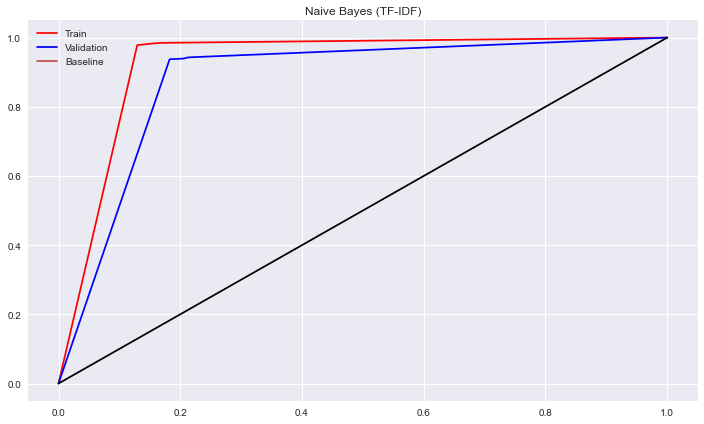

In [70]:
plotROCCurve(naiveModel, X_train, x_val, Y_train, y_val, 'Naive Bayes (TF-IDF)')

# Decision Tree

In [71]:
DecisionTree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=86)
# Fit decision tree
treeModel = DecisionTree.fit(X_train, Y_train)

In [72]:
treeModelTrain = calculatePerformance(treeModel, X_train, Y_train, 'Decision Tree Training')
treeModelTrain

,Model,F1,Accuracy,ROC_Score,Precision
0,Decision Tree Training,0.879331,0.893726,0.892354,0.994267


In [73]:
treeModelVal = calculatePerformance(treeModel, X_train, Y_train, 'Decision Tree Validation')
treeModelVal

,Model,F1,Accuracy,ROC_Score,Precision
0,Decision Tree Validation,0.879331,0.893726,0.892354,0.994267


# Evaluating all models

In [74]:
# Concate all results into a larger dataframe
evaluationDf = pd.concat([treeModelVal,
                         treeModelTrain,
                         naiveModelVal,
                         naiveModelTrain,
                         Logistic_Regression_Validation,
                         Logistic_Regression_Training])

In [75]:
evaluationDf

,Model,F1,Accuracy,ROC_Score,Precision
0,Decision Tree Validation,0.879331,0.893726,0.892354,0.994267
0,Decision Tree Training,0.879331,0.893726,0.892354,0.994267
0,Naive Bayes Validation (TF-IDF),0.881919,0.876172,0.878681,0.832753
0,Naive BayesTraining (TF-IDF),0.925761,0.922899,0.926856,0.878366
0,Logistic Regression Validation,0.973551,0.974252,0.995978,0.986981
0,Logistic Regression Model,0.983070,0.983516,0.997736,0.992056


By observing the results, we see that the Logistic Regression Model has performed the best on the data.

In [23]:
# Using best parameters with logistic regression
bestLogModel = LogisticRegression(C = 10, random_state = 1006)

In [24]:
bestLogModel.fit(X_train, Y_train)

LogisticRegression(C=10, random_state=1006)

In [25]:
coefficients = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(bestLogModel.coef_))], axis = 1)

In [26]:
coefficients.columns=['word', 'coefficient']

In [27]:
coefficients.sort_values(by = 'coefficient', ascending = False, inplace = True)
coefficients = coefficients[:25]

In [28]:
coefficients.reset_index()

,index,word,coefficient
0,717,bitch,45.098956
1,3768,hoe,31.692547
2,6412,pussy,26.061497
3,2661,faggot,18.326497
4,6713,retard,16.368213
5,5683,nigger,16.297209
6,8170,trash,16.048739
7,1859,cunt,14.665445
8,2658,fag,14.562258
9,5664,niggah,14.168948


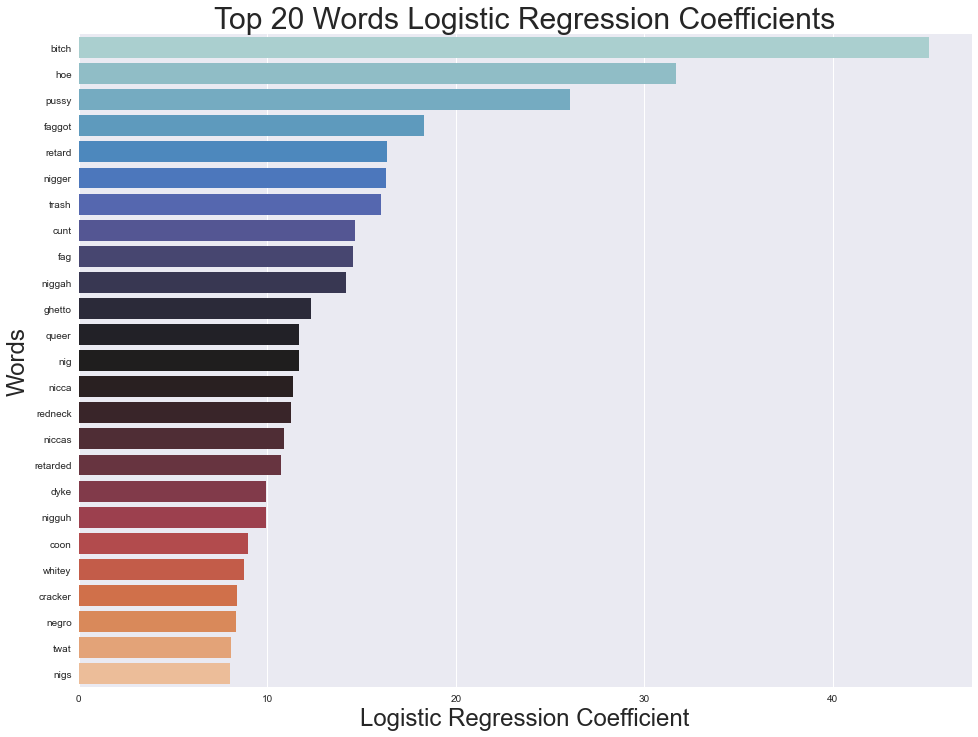

In [34]:
plt.figure(figsize=(16,12))
sns.barplot(coefficients['coefficient'],
           coefficients['word'],
           orient ='h',
           palette="icefire")

plt.xlabel('Logistic Regression Coefficient', fontsize=24)
plt.ylabel('Words', fontsize=24)
plt.title('Top 20 Words Logistic Regression Coefficients', fontsize=30)
plt.show()

# Test Logistic Regression on Test Data

In [30]:
yHatLog = bestLogModel.predict(x_test)

In [31]:
confMatrix = confusion_matrix(y_test, yHatLog)

In [32]:
calculatePerformance(bestLogModel, x_test, y_test, 'Test Set Logistic Regression Results')

,Model,F1,Accuracy,ROC_Score,Precision
0,Test Set Logistic Regression Results,0.987463,0.987856,0.997711,0.993323


In [33]:
bestLogModel

LogisticRegression(C=10, random_state=1006)

In [96]:
from joblib import dump, load

pickleLogModel = open('bestLogModel', 'wb')
pickle.dump(bestLogModel, pickleLogModel)

In [97]:
dump(bestLogModel, 'final_model')

['final_model']